In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, TruncatedSVD

In [2]:
df = pd.read_pickle("fiveCats.pkl")

---

### Split

In [3]:
df.columns

Index(['id', 'stars', 'date', 'text', 'useful', 'funny', 'cool', 'name',
       'city', 'state', 'category', 'Text_length'],
      dtype='object')

In [4]:
X_df = df.drop('category', axis=1)

y_df = df['category']

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

X_train.shape

X_test.shape

---

### Tfidf

In [9]:
vectorizer = TfidfVectorizer(stop_words='english')

termTrans = vectorizer.fit(X_train['text'])

In [10]:
X_train_term  = termTrans.transform(X_train['text'])

In [11]:
X_train_term.shape

(517403, 153378)

---

### SVD - dimensionality reduction

In [13]:
X_centered = scale(X_train_term, with_mean=False)

In [14]:
svd = TruncatedSVD(n_components=10, n_iter=7)

In [15]:
X_svd = svd.fit_transform(X_train_term)  

In [16]:
svd.singular_values_

array([119.77582187,  52.33555263,  49.0945678 ,  44.77996216,
        41.79823681,  40.86417605,  39.23323403,  38.77379979,
        37.75782632,  36.39561937])

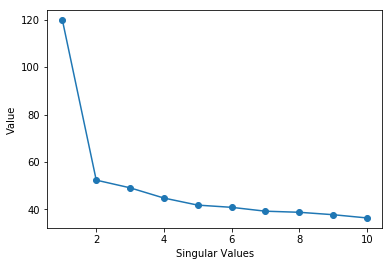

In [17]:
s = svd.singular_values_

x = [i+1 for i in range(len(s))]
plt.plot(x, s, marker='o')
plt.xlabel("Singular Values")
plt.ylabel("Value");

In [18]:
svd.explained_variance_

array([0.00312946, 0.00529288, 0.0046584 , 0.00387479, 0.00336693,
       0.00322439, 0.00297464, 0.00290567, 0.00275483, 0.00255883])

In [19]:
svd.explained_variance_ratio_

array([0.00320861, 0.00542675, 0.00477621, 0.00397278, 0.00345209,
       0.00330593, 0.00304987, 0.00297916, 0.00282451, 0.00262355])

In [20]:
X_svd.shape

(517403, 10)

---

### KMeans

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, n_jobs=-1)

In [22]:
kmeans.fit(X_svd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
# Print out the centroids.
print("\nCluster centers:")
print(kmeans.cluster_centers_)


Cluster centers:
[[ 0.18228339 -0.07692559 -0.04838772  0.06779744  0.00767893  0.01091632
  -0.018      -0.01984398  0.00185338  0.00500899]
 [ 0.18857081  0.11460932 -0.03383267  0.00410074 -0.00445603  0.03475242
  -0.00763856 -0.00889979 -0.01211165  0.00153124]
 [ 0.18041927  0.01580211  0.14842673  0.03129908  0.01417226 -0.00342476
  -0.01493756  0.00080862  0.04285377  0.01111897]
 [ 0.17438382 -0.04084372  0.00193105 -0.07978318 -0.01179172  0.00641159
  -0.01008459  0.00038248 -0.00527562  0.0100825 ]
 [ 0.12161112  0.00383308 -0.00714448 -0.00041162 -0.00714538 -0.02277857
   0.01963952  0.01033667 -0.00295419 -0.01292969]]


In [ ]:
# Find the top 10 features for each cluster.
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print("\nTop features (words) for each cluster:\n")
for num, centroid in enumerate(top_centroids):
        print("%d: %s" % (num, ", ".join(features[i] for i in centroid)))

In [ ]:
features = vectorizer.get_feature_names()

In [ ]:
len(features)

In [ ]:
[features[:3]]

---

#### Pickle models

In [24]:
import pickle
pickle.dump(termTrans, open('pkl_tfidf.p','wb'))
pickle.dump(svd, open('pkl_svd.p','wb'))
pickle.dump(kmeans, open('pkl_kmeans.p','wb'))

---

#### Un-Pickle models

In [ ]:
m_termTrans = pickle.load(open('pkl_tfidf.p','rb'))
m_svd = pickle.load(open('pkl_svd.p','rb'))
m_kmeans = pickle.load(open('pkl_kmeans.p','rb'))

---

### Predict

In [ ]:
# X_test, y_test

In [ ]:
import numpy as np

In [ ]:
X_test_term = termTrans.transform(X_test['text'])

X_test_term_svd = svd.transform(X_test_term)

X_test_term_svd.shape

pred = kmeans.predict(X_test_term_svd)

np.unique(pred, return_counts=True)

In [ ]:
import numpy as np

def catPred(kmObj, gTrue): 
    '''
        kmObjn: a kmeans object
        gTrue: true categories (ground truth)
    '''
    fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(50,12))

    numClusters = kmObj.get_params()['n_clusters']
    
    for i in range(numClusters):
        mask = (pred == i)
        val = np.unique( gTrue[mask], return_counts=True)
        lbl = val[0]
        ht  = val[1] / val[1].sum()
        ax[i].bar(range(numClusters), height=ht, tick_label = lbl)
        ax[i].set_xticklabels(lbl, fontsize=20)
        ax[i].set_title(i, fontsize=20)

        ax[0].set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8"], fontsize=20)
        ax[0].set_ylabel("Proportion", fontsize = 32);
        plt.suptitle("Proportion of Categories in each Clusterc", fontsize = 32);
#         plt.suptitle("Proportion of Categories in each Clusterc", y=0, fontsize = 32);



In [ ]:
catPred(kmeans, y_test)

In [ ]:
pred

In [ ]:
len(pred)

---

##### ?Eval on Train

In [ ]:
train_pred = kmeans.predict(X_svd)

In [ ]:
len(train_pred)

In [ ]:
mask = (pred == 1)
a = np.unique(y_test[mask], return_counts=True)

a[0]

type(a[1][0])

In [ ]:
# barh - horizontal bar

In [ ]:
ht = a[1]/a[1].sum()

In [ ]:
fig, ax = plt.subplots(1,5, sharey=True)
plt.figure(figsize=(30,12))

ax[2].bar(range(kmeans.get_params()['n_clusters']), height=ht, tick_label = lbl);

ax[0].bar(range(kmeans.get_params()['n_clusters']), height=ht, tick_label = lbl);

In [ ]:
# %%time  - Time execution of a Python statement, expression or cell

np.sum(a[1])

In [ ]:
%%time
a[1].sum()

In [ ]:
x = df['category'].value_counts().values
lbls = list(df['category'].value_counts().index)
plt.bar(range(len(x)), height=x, tick_label = lbls);

In [ ]:
p = pd.DataFrame(pred)

In [ ]:
p[0].value_counts()

In [ ]:
pred

In [ ]:
y

In [ ]:
plt.hist(pred)

In [ ]:
svd.transform([features])

In [ ]:
# len(vectorizer.get_feature_names())

# type(X)

In [ ]:
# X_svd[0]

# svd.get_params()

# svd.components_.shape